In [8]:
import os.path
import math
import numpy as np
import matplotlib.pyplot as plt
import os

## 1: Data Generator

In [10]:
from tensorflow.keras.utils import Sequence

class GenData(Sequence):
    def __init__(self, path, split='train', batch_size=32):
        self.batch_size = batch_size
        self.split = split
        self.path = os.path.join(path, split)
        self.path_list = []
        #self.y = []
        #self.X = []

        for root, directories, files in os.walk(self.path, topdown=True):
            for filename in files:
                # Join the two strings in order to form the full filepath.
                filepath = os.path.join(root, filename)
                self.path_list.append(filepath)
                #Xy = np.load(filepath)
                #self.X.append(Xy['features'])
                #self.y.append(Xy['vad'])

        self.idx = np.random.permutation(len(self.path_list))

    def __len__(self):
        return math.floor(len(self.path_list) / self.batch_size)

    def __getitem__(self, item):
        idx_batch = self.idx[item*self.batch_size : (item+1)*self.batch_size]
        X_batch = []
        y_batch = []
        for it, rand_it in enumerate(idx_batch):
            Xy = np.load(self.path_list[rand_it])
            X_batch.append(Xy['features'].T)
            y_batch.append(Xy['vad'].T)
        minlen = min([it.shape[0] for it in X_batch])
        X_batch = np.stack([a[:minlen] for a in X_batch])
        y_batch = np.stack([a[:minlen] for a in y_batch])
        y_batch[y_batch > 0.5] = 1
        y_batch[y_batch < 0.5] = 0

        y_batch = np.expand_dims(y_batch, -1)
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.split == 'train':
            self.idx = np.random.permutation(len(self.path_list))

In [11]:
# Instantiate one generator for training, validation and test data

batch_size = 16
path = 'H:/Uni/ss21/Python Lab/Project/07_deeplearning/Training Data Lab Course 7/'

gen_train_data = GenData(path, split='train', batch_size=batch_size)
gen_val_data = GenData(path, split='val', batch_size=batch_size)
gen_test_data = GenData(path, split='test', batch_size=batch_size)

x0, y0 = gen_train_data.__getitem__(0)
print(x0.shape)
print(y0.shape)

(16, 236, 62)
(16, 236, 1)


In [4]:
# Draw a batch from the training generator, and verify that the samples have the correct shape.

## 2: First Experiment

In [14]:
# In the function build_model construct and compile the following neural network.
# It is intended to predict the probability of speech being present.

# In the function build_model construct and compile the following neural network.
# It is intended to predict the probability of speech being present.

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

def build_model():
    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [26]:
# Train the model for 10 epochs and store the training history.

model = build_model()

opt = Adam(learning_rate=0.001)
loss = BinaryCrossentropy()
acc = BinaryAccuracy()

model.compile(optimizer=opt, loss=loss, metrics=[acc])

history = model.fit(gen_train_data, validation_data=gen_val_data, epochs=10)
print(model.summary())

Epoch 1/10
237/237 [==============================] - 7s 24ms/step - loss: 0.5283 - binary_accuracy: 0.7347 - val_loss: 0.7122 - val_binary_accuracy: 0.5724

## 3: Evaluation

In [ ]:
# Compute and display the metrics on the test set
%matplotlib qt

results = model.evaluate(gen_test_data)

#plt.plot(history.history['loss'], label='train loss')
# plt.plot(results[0], label='test loss')
# plt.plot(results[1], label='test acc')
# plt.xlabel('Epochs')
# plt.legend()
# plt.show()

#test_data = GenData(path, split='test', batch_size=1)
#acc_test = model.evaluate(test_data)
evaluate = model.evaluate(gen_test_data)
print("Test loss and accuracy: ", evaluate)
#print(acc_test)

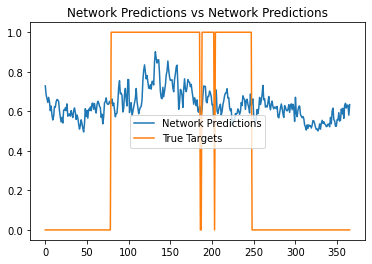

In [24]:
# Select a sentence from the test set and plot the true targets and the network’s predictions in one diagram.

def plot_example(mdl, gen):
    '''
        mdl: model
        gen: Generator
    '''

    batch_size = 1
    gen_test_data = gen(path, split='test', batch_size=batch_size)
    x0_test, y0_test = gen_test_data.__getitem__(0)
    pred0 = mdl.predict(x0_test, batch_size=1, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

    plt.plot(pred0[0,:,0], label='Network Predictions')
    plt.plot(y0_test[0,:,0], label='True Targets')
    plt.title("Network Predictions vs Network Predictions")
    plt.legend()

plot_example(model, GenData)

## 4: Gated Activation Functions

In [12]:
from tensorflow.keras.layers import Multiply, Input

def build_gated_model():
    input = Input(x0.shape[1:])

    #netin = Input((None, train_data.num_mfcc))
    #norm = BatchNormalization()(netin)

    x1 = BatchNormalization()(input)
    x2 = Dense(32, activation="sigmoid")(x1)

    x3 = Dense(32, activation="tanh")(x1)

    x4 = Multiply()([x2, x3])
    x4 = BatchNormalization()(x4)
    x5 = Dense(32, activation="sigmoid")(x4)

    x6 = Dense(32, activation="tanh")(x4)

    x7 = Multiply()([x5, x6])
    x7 = BatchNormalization()(x7)
    output = Dense(1, activation="sigmoid")(x7)
    model = Model(inputs=input, outputs=output)

    return model

In [ ]:
# fit and evaluate

modelGated = build_gated_model()

modelGated.compile(optimizer=opt, loss=loss, metrics=[acc])
modelGated.fit(gen_train_data, epochs=10, validation_data=gen_val_data)
modelGated.evaluate(gen_test_data)

In [ ]:
# fit and evaluate

## 5: A Recurrent Network

In [15]:
from tensorflow.keras.layers import Dense

def build_rnn():

    modelRNN = Sequential()
    # modelRNN.add(InputLayer((None, *x0.shape[2:])))
    modelRNN.add(BatchNormalization())
    modelRNN.add(LSTM(32, return_sequences=True))
    modelRNN.add(BatchNormalization())
    modelRNN.add(LSTM(32, return_sequences=True))
    modelRNN.add(BatchNormalization())
    modelRNN.add(Dense(1, activation='sigmoid'))

    return modelRNN

In [17]:
# train the model

modelRNN = build_rnn()
opt = Adam(learning_rate=0.001)
loss = BinaryCrossentropy()
acc = BinaryAccuracy()

modelRNN.compile(optimizer=opt, loss=loss, metrics=[acc])

history =  modelRNN.fit(gen_train_data, validation_data=gen_val_data, epochs=5)
print(modelRNN.summary())

Epoch 1/5
237/237 [==============================] - 23s 83ms/step - loss: 0.3906 - binary_accuracy: 0.8325 - val_loss: 0.8087 - val_binary_accuracy: 0.5748

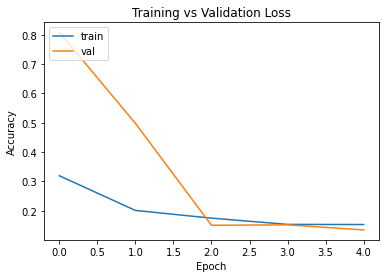

In [22]:
# Plot the training and validation loss for the RNN and the network from exercise 1.4 in one diagram.
#print(history.history)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training vs Validation Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

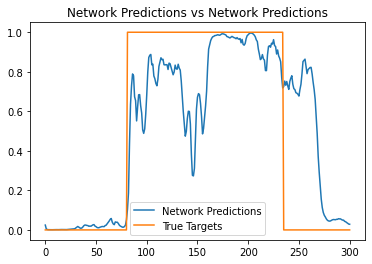

In [25]:
# Plot the recurrent networks prediction for the previously chosen instance from the test set.

plot_example(modelRNN, GenData)

## 6: Batch Size

In [ ]:
for batch_size in [4, 8, 16, 32, 64, 128]:

    gen_train_data = GenData(path, split='train', batch_size=batch_size)
    gen_val_data = GenData(path, split='val', batch_size=batch_size)
    gen_test_data = GenData(path, split='test', batch_size=batch_size)

    opt = Adam(learning_rate=0.001)
    loss = BinaryCrossentropy()
    acc = BinaryAccuracy()
    modelRNN.compile(optimizer=opt, loss=loss, metrics=[acc])

    history =  modelRNN.fit(gen_train_data, validation_data=gen_val_data, epochs=1)


## Optional: 7: Hyperparameter Tuning

In [ ]:
from kerastuner import HyperParameters

def hypermodel(hp: HyperParameters):
    pass

In [ ]:
import kerastuner as kt
from shutil import rmtree


